<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

© Copyright Quantopian Inc.<br>
© Modifications Copyright QuantRocket LLC<br>
Licensed under the [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/legalcode).<br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Quant Finance Lectures (adapted Quantopian Lectures)](Introduction.ipynb) › Lecture 18 - Residual Analysis
***

# Residuals Analysis

By Chris Fenaroli and Max Margenot 


## Linear Regression

Linear regression is one of our most fundamental modeling techniques. We use it to estimate a linear relationship between a set of independent variables $X_i$ and a dependent outcome variable $y$. Our model takes the form of:

$$ y_i = \beta_{0} 1 + \beta_{i, 1} x_{i, 1} + \dots + \beta_{i, p} x_{i, p} + \epsilon_i = x_i'\beta + \epsilon_i $$

For $i \in \{1, \dots, n\}$, where $n$ is the number of observations. We write this in vector form as:

$$ y = X\beta + \epsilon $$

Where $y$ is a $n \times 1$ vector, $X$ is a $n \times p$ matrix, $\beta$ is a $p \times 1$ vector of coefficients, and $\epsilon$ is a standard normal error term. Typically we call a model with $p = 1$ a simple linear regression and a model with $p > 1$ a multiple linear regression. More background information on regressions can be found in the lectures on [simple linear regression](Lecture12-Linear-Regression.ipynb) and [multiple linear regression](Lecture15-Multiple-Linear-Regression.ipynb).

Whenever we build a model, there will be gaps between what a model predicts and what is observed in the sample. The differences between these values are known as the residuals of the model and can be used to check for some of the basic assumptions that go into the model. The key assumptions to check for are:

* **Linear Fit:** The underlying relationship should be linear
* **Homoscedastic:** The data should have no trend in the variance
* **Independent and Identically Distributed:** The residuals of the regression should be independent and identically distributed (i.i.d.) and show no signs of serial correlation

We can use the residuals to help diagnose whether the relationship we have estimated is real or spurious.

Statistical error is a similar metric associated with regression analysis with one important difference: While residuals quantify the gap between a regression model predictions and the observed sample, statistical error is the difference between a regression model and the unobservable expected value. We use residuals in an attempt to estimate this error.

In [1]:
# Import libraries
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
import scipy.stats as stats
import matplotlib.pyplot as plt

### Simple Linear Regression

First we'll define a function that performs linear regression and plots the results.

In [2]:
def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    B0 = model.params[0]
    B1 = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * B1 + B0
    plt.scatter(X, Y, alpha=1) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=1);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model, B0, B1

Let's define a toy relationship between $X$ and $Y$ that we can model with a linear regression. Here we define the relationship and construct a model on it, drawing the determined line of best fit with the regression parameters.

Line of best fit: Y = 9.903565361361307 + 0.5025633431808287*X


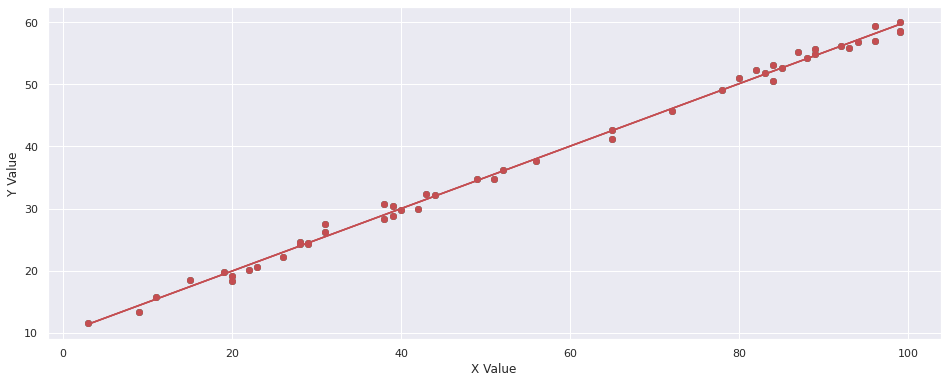

In [3]:
n = 50
X = np.random.randint(0, 100, n)
epsilon = np.random.normal(0, 1, n)

Y = 10 + 0.5 * X + epsilon

linreg(X,Y)[0];
print("Line of best fit: Y = {0} + {1}*X".format(linreg(X, Y)[1], linreg(X, Y)[2]))

This toy example has some generated noise, but all real data will also have noise. This is inherent in sampling from any sort of wild data-generating process. As a result, our line of best fit will never exactly fit the data (which is why it is only "best", not "perfect"). Having a model that fits every single observation that you have is a sure sign of overfitting.

For all fit models, there will be a difference between what the regression model predicts and what was observed, which is where residuals come in.

## Residuals

The definition of a residual is the difference between what is observed in the sample and what is predicted by the regression. For any residual $r_i$, we express this as 

$$r_i = Y_i - \hat{Y_i}$$

Where $Y_i$ is the observed $Y$-value and $\hat{Y}_i$ is the predicted Y-value. We plot these differences on the following graph:

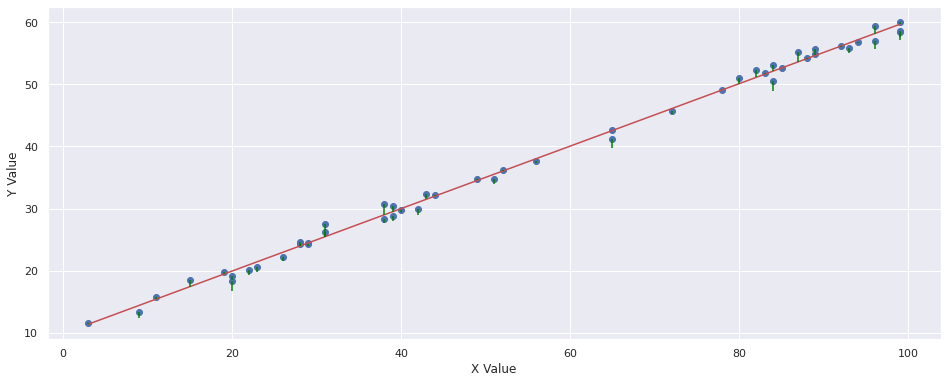

In [4]:
model, B0, B1 = linreg(X,Y)

residuals = model.resid
plt.errorbar(X,Y,xerr=0,yerr=[abs(residuals),0*residuals],linestyle="None",color='Green');

We can pull the residuals directly out of the fit model.

In [5]:
residuals = model.resid
print(residuals)

[ 0.15840558 -1.02780842  0.7529739  -1.61593996  0.98132761 -0.7520329
  0.10742439 -1.44485792  0.40928055  1.15930016  0.29444334  1.14142008
 -0.65078558  1.70285918 -0.03244775 -1.22861598  0.37060067 -1.21774252
 -0.7230771  -0.8487655  -0.37435134 -0.80080827 -0.76384905  0.87917409
 -0.681522   -0.42893441  0.22202087  0.14586144  1.56019886 -0.81154579
  2.03267621  1.04638167  0.3981656   0.06236022 -0.28047306 -0.03685226
 -0.01593137  0.9085493  -0.28050507 -0.21519923 -1.56626193  0.73346112
  0.97703852  1.04218201  0.13777378 -1.06465201  0.01279966  0.32769238
 -1.00731662  0.30590488]


### Diagnosing Residuals

Many of the assumptions that are necessary to have a valid linear regression model can be checked by identifying patterns in the residuals of that model. We can make a quick visual check by looking at the residual plot of a given model.

With a residual plot, we look at the predicted values of the model versus the residuals themselves. What we want to see is just a cloud of unrelated points, like so:

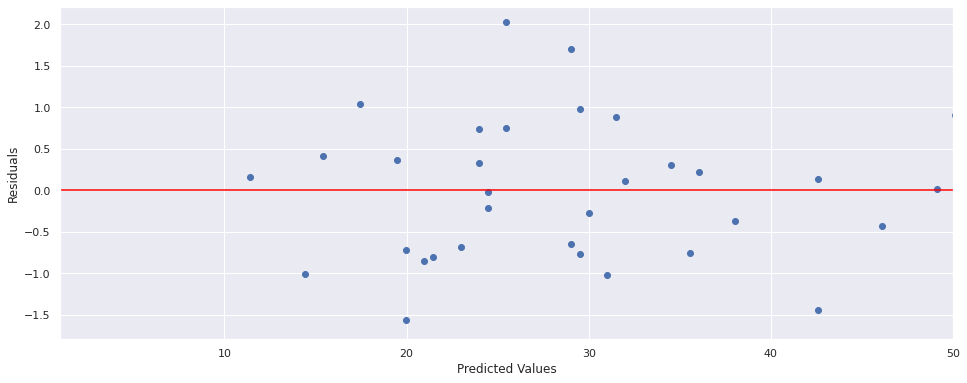

In [6]:
plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');
plt.xlim([1,50]);

What we want is a fairly random distribution of residuals. The points should form no discernible pattern. This would indicate that a plain linear model is likely a good fit. If we see any sort of trend, this might indicate the presence of autocorrelation or heteroscedasticity in the model.

## Appropriateness of a Linear Model

By looking for patterns in residual plots we can determine whether a linear model is appropriate in the first place. A plain linear regression would not be appropriate for an underlying relationship of the form:

$$Y = \beta_0 + \beta_1 X^2$$

as a linear function would not be able to fully explain the relationship between $X$ and $Y$.

If the relationship is not a good fit for a linear model, the residual plot will show a distinct pattern. In general, a residual plot of a linear regression on a non-linear relationship will show bias and be asymmetrical with respect to residual = 0 line while a residual plot of a linear regression on a linear relationship will be generally symmetrical over the residual = 0 axis.

As an example, let's consider a new relationship between the variables $X$ and $Y$ that incorporates a quadratic term.

beta_0: 18.943882843621143
beta_1: -2.3166389252576205


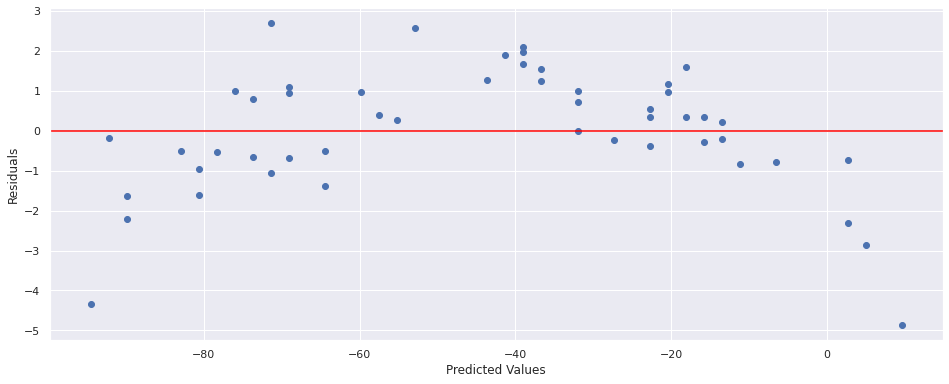

In [7]:
n = 50
X = np.random.randint(0, 50, n)
epsilon = np.random.normal(0, 1, n)
Y_nonlinear = 10 - X**1.2 + epsilon

model = sm.OLS(Y_nonlinear, sm.add_constant(X)).fit()
B0, B1 = model.params
residuals = model.resid

print('beta_0:', B0)
print('beta_1:', B1)
plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

The "inverted-U" shape shown by the residuals is a sign that a non-linear model might be a better fit than a linear one.

## Heteroscedasticity

One of the main assumptions behind a linear regression is that the underlying data has a constant variance. If there are some parts of the data with a variance different from another part the data is not appropriate for a linear regression. **Heteroscedasticity** is a term that refers to data with non-constant variance, as opposed to homoscedasticity, when data has constant variance.

Significant heteroscedasticity invalidates linear regression results by biasing the standard error of the model. As a result, we can't trust the outcomes of significance tests and confidence intervals generated from the model and its parameters.

To avoid these consequences it is important to use residual plots to check for heteroscedasticity and adjust if necessary.

As an example of detecting and correcting heteroscedasticity, let's consider yet another relationship between $X$ and $Y$:

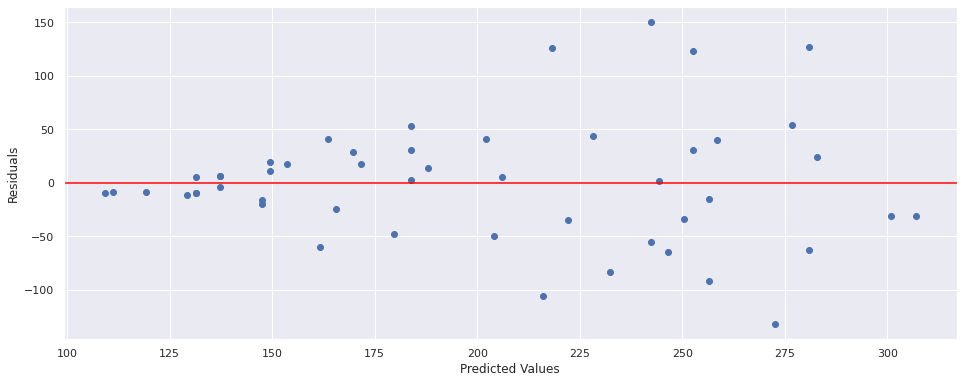

In [8]:
n = 50
X = np.random.randint(0, 100, n)
epsilon = np.random.normal(0, 1, n)
Y_heteroscedastic = 100 + 2*X + epsilon*X

model = sm.OLS(Y_heteroscedastic, sm.add_constant(X)).fit()
B0, B1 = model.params
residuals = model.resid

plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

Heteroscedasticity often manifests as this spread, giving us a tapered cloud in one direction or another. As we move along in the $x$-axis, the magnitudes of the residuals are clearly increasing. A linear regression is unable to explain this varying variability and the regression standard errors will be biased.

### Statistical Methods for Detecting Heteroscedasticity

Generally, we  want to back up qualitative observations on a residual plot with a quantitative method. The residual plot led us to believe that the data might be heteroscedastic. Let's confirm that result with a statistical test.

A common way to test for the presence of heteroscedasticity is the Breusch-Pagan hypothesis test. It's good to combine the qualitative analysis of a residual plot with the quantitative analysis of at least one hypothesis test. We can add the White test as well, but for now we will use only Breush-Pagan to test our relationship above. A function exists in the `statsmodels` package called `het_breushpagan` that simplifies the computation:

In [9]:
breusch_pagan_p = smd.het_breuschpagan(model.resid, model.model.exog)[1]
print(breusch_pagan_p)
if breusch_pagan_p > 0.05:
    print("The relationship is not heteroscedastic.")
if breusch_pagan_p < 0.05:
    print("The relationship is heteroscedastic.")

0.002225248032864744
The relationship is heteroscedastic.


We set our confidence level at $\alpha = 0.05$, so a Breusch-Pagan p-value below $0.05$ tells us that the relationship is heteroscedastic. For more on hypothesis tests and interpreting p-values, refer to the lecture on hypothesis testing. Using a hypothesis test bears the risk of a false positive or a false negative, which is why it can be good to confirm with additional tests if we are skeptical.

### Adjusting for Heteroscedasticity

If, after creating a residual plot and conducting tests, you believe you have heteroscedasticity, there are a number of methods you can use to attempt to adjust for it. The three we will focus on are differences analysis, log transformations, and Box-Cox transformations.

#### Differences Analysis

A differences analysis involves looking at the first-order differences between adjacent values. With this, we are looking at the changes from period to period of an independent variable rather than looking directly at its values. Often, by looking at the differences instead of the raw values, we can remove heteroscedasticity. We correct for it and can use the ensuing model on the differences.

In [10]:
# Finding first-order differences in Y_heteroscedastic
Y_heteroscedastic_diff = np.diff(Y_heteroscedastic)

Now that we have stored the first-order differences of `Y_heteroscedastic` in `Y_heteroscedastic_diff` let's repeat the regression and residual plot to see if the heteroscedasticity is still present:

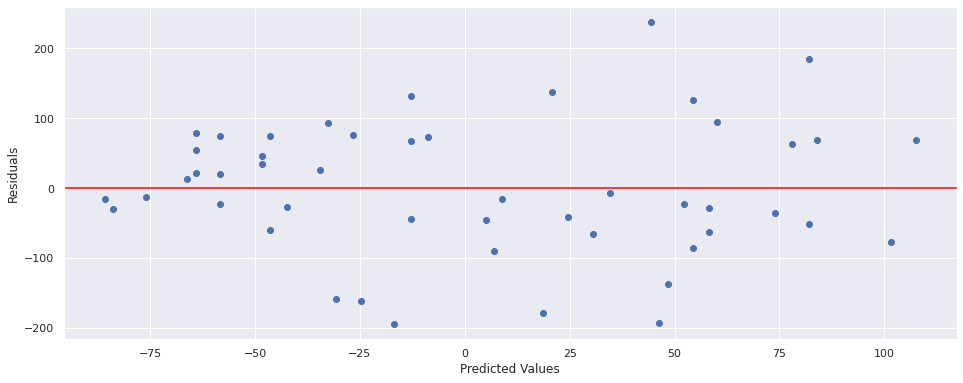

In [11]:
model = sm.OLS(Y_heteroscedastic_diff, sm.add_constant(X[1:])).fit()
B0, B1 = model.params
residuals = model.resid

plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

In [12]:
breusch_pagan_p = smd.het_breuschpagan(residuals, model.model.exog)[1]
print(breusch_pagan_p)
if breusch_pagan_p > 0.05:
    print("The relationship is not heteroscedastic.")
if breusch_pagan_p < 0.05:
    print("The relationship is heteroscedastic.")

0.09768613568782415
The relationship is not heteroscedastic.


*Note: This new regression was conducted on the differences between data, and therefore the regression output must be back-transformed to reach a prediction in the original scale. Since we regressed the differences, we can add our predicted difference onto the original data to get our estimate:*

$$\hat{Y_i} = Y_{i-1} + \hat{Y}_{diff}$$

#### Logarithmic Transformation

Next, we apply a log transformation to the underlying data. A log transformation will bring residuals closer together and ideally remove heteroscedasticity. In many (though not all) cases, a log transformation is sufficient in stabilizing the variance of a relationship.

In [13]:
# Taking the log of the previous data Y_heteroscedastic and saving it in Y_heteroscedastic_log
Y_heteroscedastic_log = np.log(Y_heteroscedastic)

Now that we have stored the log transformed version of `Y_heteroscedastic` in `Y_heteroscedastic_log` let's repeat the regression and residual plot to see if the heteroscedasticity is still present:

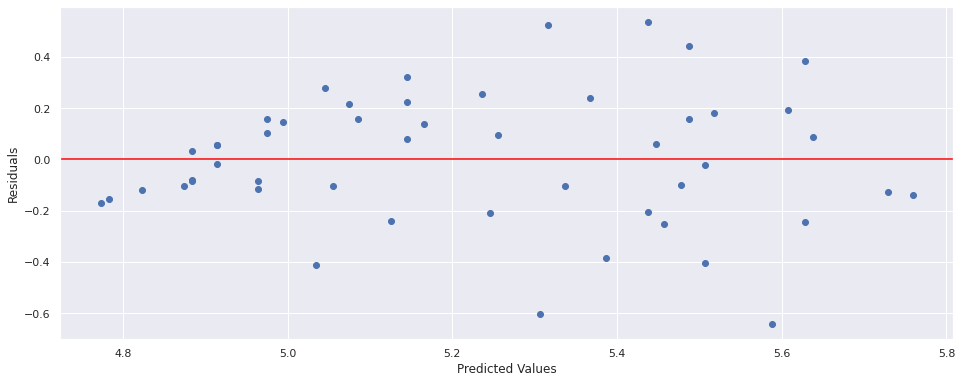

In [14]:
model = sm.OLS(Y_heteroscedastic_log, sm.add_constant(X)).fit()
B0, B1 = model.params
residuals = model.resid

plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

In [15]:
# Running and interpreting a Breusch-Pagan test
breusch_pagan_p = smd.het_breuschpagan(residuals, model.model.exog)[1]
print(breusch_pagan_p)
if breusch_pagan_p > 0.05:
    print("The relationship is not heteroscedastic.")
if breusch_pagan_p < 0.05:
    print("The relationship is heteroscedastic.")

0.023237127861009448
The relationship is heteroscedastic.


*Note: This new regression was conducted on the log of the original data. This means the scale has been altered and the regression estimates will lie on this transformed scale. To bring the estimates back to the original scale, you must back-transform the values using the inverse of the log:*

$$\hat{Y} = e^{\log(\hat{Y})}$$

#### Box-Cox Transformation

Finally, we examine the Box-Cox transformation. The Box-Cox transformation is a powerful method that will work on many types of heteroscedastic relationships. The process works by testing all values of $\lambda$ within the range $[-5, 5]$ to see which makes the output of the following equation closest to being normally distributed:
$$
Y^{(\lambda)} = \begin{cases}
    \frac{Y^{\lambda}-1}{\lambda} & : \lambda \neq 0\\ \log{Y} & : \lambda = 0
\end{cases}
$$

The "best" $\lambda$ will be used to transform the series along the above function. Instead of having to do all of this manually, we can simply use the `scipy` function `boxcox`. We use this to adjust $Y$ and hopefully remove heteroscedasticity.

*Note: The Box-Cox transformation can only be used if all the data is positive* 

In [16]:
# Finding a power transformation adjusted Y_heteroscedastic
Y_heteroscedastic_box_cox = stats.boxcox(Y_heteroscedastic)[0]

Now that we have stored the power transformed version of `Y_heteroscedastic` in `Y_heteroscedastic_prime` let's repeat the regression and residual plot to see if the heteroscedasticity is still present:

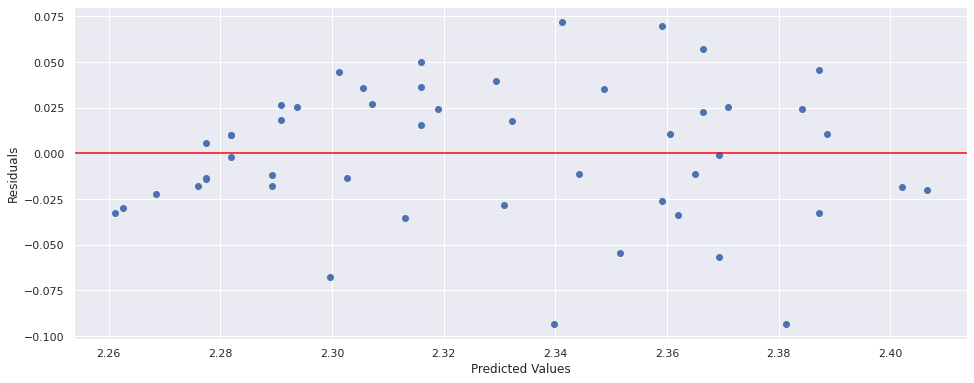

In [17]:
model = sm.OLS(Y_heteroscedastic_box_cox, sm.add_constant(X)).fit()
B0, B1 = model.params
residuals = model.resid

plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

In [18]:
# Running and interpreting a Breusch-Pagan test
breusch_pagan_p = smd.het_breuschpagan(residuals, model.model.exog)[1]
print(breusch_pagan_p)
if breusch_pagan_p > 0.05:
    print("The relationship is not heteroscedastic.")
if breusch_pagan_p < 0.05:
    print("The relationship is heteroscedastic.")

0.09010257229686909
The relationship is not heteroscedastic.


*Note: Now that the relationship is not heteroscedastic, a linear regression is appropriate. However, because the data was power transformed, the regression estimates will be on a different scale than the original data. This is why it is important to remember to back-transform results using the inverse of the Box-Cox function:*

$$\hat{Y} = (Y^{(\lambda)}\lambda + 1)^{1/\lambda}$$


### GARCH Modeling

Another approach to dealing with heteroscadasticity is through a GARCH (generalized autoregressive conditional heteroscedasticity) model. More information can be found in the lecture on GARCH modeling.

## Residuals and Autocorrelation

Another assumption behind linear regressions is that the residuals are not autocorrelated. A series is autocorrelated when it is correlated with a delayed version of itself. An example of a potentially autocorrelated time series series would be daily high temperatures. Today's temperature gives you information on tomorrow's temperature with reasonable confidence (i.e. if it is 90 °F today, you can be very confident that it will not be below freezing tomorrow). A series of fair die rolls, however, would not be autocorrelated as seeing one roll gives you no information on what the next might be. Each roll is independent of the last.

In finance, stock prices are usually autocorrelated while stock returns are independent from one day to the next. We represent a time dependency on previous values like so:

$$Y_i = Y_{i-1} + \epsilon$$

If the residuals of a model are autocorrelated, you will be able to make predictions about adjacent residuals. In the case of $Y$, we know the data will be autocorrelated because we can make predictions based on adjacent residuals being close to one another.

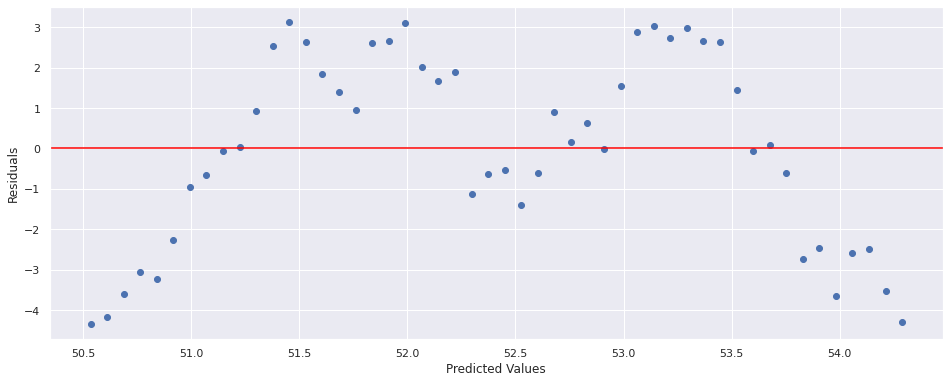

In [19]:
n = 50
X = np.linspace(0, n, n)
Y_autocorrelated = np.zeros(n)
Y_autocorrelated[0] = 50
for t in range(1, n):
    Y_autocorrelated[t] = Y_autocorrelated[t-1] + np.random.normal(0, 1) 

# Regressing X and Y_autocorrelated
model = sm.OLS(Y_autocorrelated, sm.add_constant(X)).fit()
B0, B1 = model.params
residuals = model.resid

plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

Autocorrelation in the residuals in this example is not explicitly obvious, so our check is more to make absolutely certain.

### Statistical Methods for Detecting Autocorrelation

As with all statistical properties, we require a statistical test to ultimately decide whether there is autocorrelation in our residuals or not. To this end, we use a Ljung-Box test.

A Ljung-Box test is used to detect autocorrelation in a time series. The Ljung-Box test examines autocorrelation at all lag intervals below a specified maximum and returns arrays containing the outputs for every tested lag interval.

Let's use the `acorr_ljungbox` function in `statsmodels` to test for autocorrelation in the residuals of our above model. We use a max lag interval of $10$, and see if any of the lags have significant autocorrelation:

In [20]:
ljung_box = smd.acorr_ljungbox(residuals, lags=10, return_df=True)
print("Lagrange Multiplier Statistics:", ljung_box.lb_stat.tolist())
print("\nP-values:", ljung_box.lb_pvalue.tolist(), "\n")

if (ljung_box.lb_pvalue < 0.05).any():
    print("The residuals are autocorrelated.")
else:
    print("The residuals are not autocorrelated.")

Lagrange Multiplier Statistics: [38.06977722167456, 64.33165718941287, 81.58372154344417, 90.69941556216888, 93.76386763266596, 94.04791187647284, 94.56411591182605, 96.85406305941034, 102.04768229374312, 111.14844071911955]

P-values: [6.825929692333136e-10, 1.0728972582608164e-14, 1.403752323095836e-17, 9.352315626062198e-19, 1.0867426640912258e-18, 4.363445479629903e-18, 1.425288940607941e-17, 1.873656310467215e-17, 6.059079164743287e-18, 3.129815518114293e-19] 

The residuals are autocorrelated.


Because the Ljung-Box test yielded a p-value below $0.05$ for at least one lag interval, we can conclude that the residuals of our model are autocorrelated.

## Adjusting for Autocorrelation

We can adjust for autocorrelation in many of the same ways that we adjust for heteroscedasticity. Let's see if a model on the first-order differences of $Y$ has autocorrelated residuals:

In [21]:
# Finding first-order differences in Y_autocorrelated
Y_autocorrelated_diff = np.diff(Y_autocorrelated)

P-values: [0.8492769258637699, 0.9800545673773886, 0.9512689456593788, 0.7946526380566942, 0.8598484711325798, 0.9215376983600388, 0.6981504583909952, 0.7707288087664473, 0.7995099495265586, 0.7355263299054354] 

The residuals are not autocorrelated.


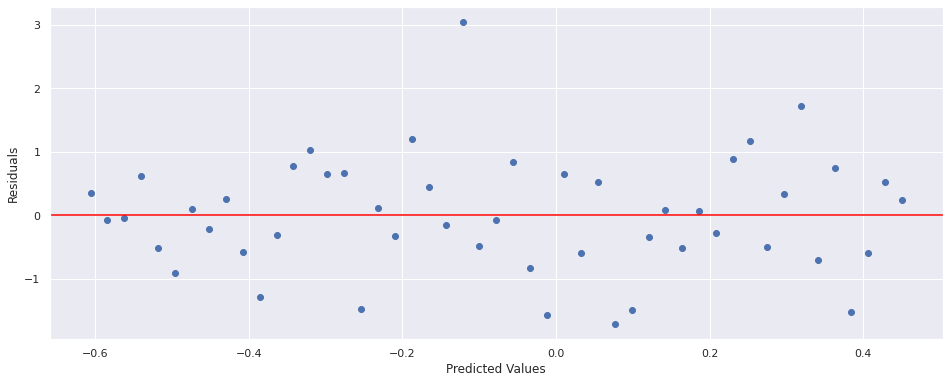

In [22]:
model = sm.OLS(Y_autocorrelated_diff, sm.add_constant(X[1:])).fit()
B0, B1 = model.params
residuals = model.resid

plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

# Running and interpreting a Ljung-Box test
ljung_box = smd.acorr_ljungbox(residuals, lags=10, return_df=True)
print("P-values:", ljung_box.lb_pvalue.tolist(), "\n")

if (ljung_box.lb_pvalue < 0.05).any():
    print("The residuals are autocorrelated.")
else:
    print("The residuals are not autocorrelated.")

*Note: This new regression was conducted on the differences between data, and therefore the regression output must be back-transformed to reach a prediction in the original scale. Since we regressed the differences, we can add our predicted difference onto the original data to get our estimate:*

$$\hat{Y_i} = Y_{i-1} + \hat{Y_{diff}}$$

We can also perform a log transformation, if we so choose. This process is identical to the one we performed on the heteroscedastic data up above, so we will leave it out this time.

## Example: Market Beta Calculation

Let's calculate the market beta between AAPL and SPY using a simple linear regression, and then conduct a residual analysis on the regression to ensure the validity of our results. To regress AAPL and SPY, we will focus on their returns, not their price, and set SPY returns as our independent variable and AAPL returns as our outcome variable. The regression will give us a line of best fit: 

$$\hat{r_{AAPL}} = \hat{\beta_0} + \hat{\beta_1}r_{SPY}$$

The slope of the regression line $\hat{\beta_1}$ will represent our market beta, as for every $r$ percent change in the returns of SPY, the predicted returns of AAPL will change by $\hat{\beta_1}$.

Let's start by conducting the regression the returns of the two assets.

Estimated AAPL Beta: 1.3581269283181543


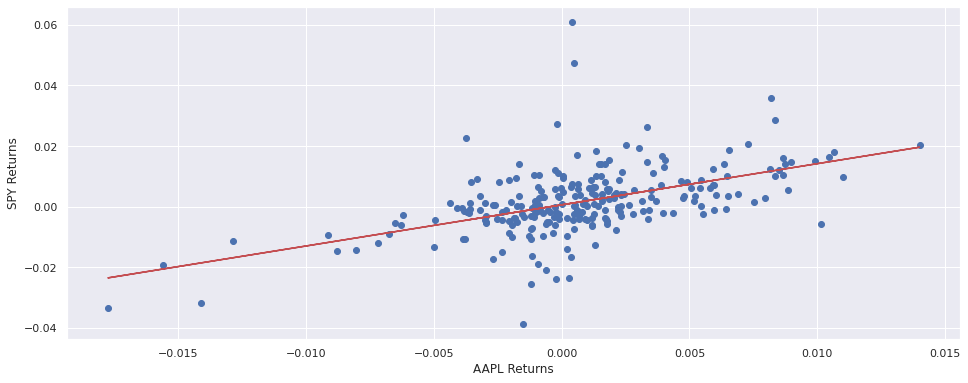

In [23]:
from quantrocket.master import get_securities
from quantrocket import get_prices

securities = get_securities(symbols=["AAPL", "SPY"], vendors='usstock')

start = '2017-01-01'
end = '2018-01-01'

closes = get_prices("usstock-free-1min", data_frequency="daily", sids=securities.index.tolist(), fields='Close', start_date=start, end_date=end).loc['Close']

sids_to_symbols = securities.Symbol.to_dict()
closes = closes.rename(columns=sids_to_symbols)

asset = closes['AAPL']
benchmark = closes['SPY']

# We have to take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
r_a = asset.pct_change()[1:].values
r_b = benchmark.pct_change()[1:].values

# Regressing the benchmark b and asset a
r_b = sm.add_constant(r_b)
model = sm.OLS(r_a, r_b).fit()
r_b = r_b[:, 1]
B0, B1 = model.params

# Plotting the regression
A_hat = (B1*r_b + B0)
plt.scatter(r_b, r_a, alpha=1) # Plot the raw data
plt.plot(r_b, A_hat, 'r', alpha=1);  # Add the regression line, colored in red
plt.xlabel('AAPL Returns')
plt.ylabel('SPY Returns')

# Print our result
print("Estimated AAPL Beta:", B1)

# Calculating the residuals
residuals = model.resid

Our regression yielded an estimated market beta of 1.36; according to the regression, for every 1% in return we see from the SPY, we should see 1.36% from AAPL.

Now that we have the regression results and residuals, we can conduct our residual analysis. Our first step will be to plot the residuals and look for any red flags:

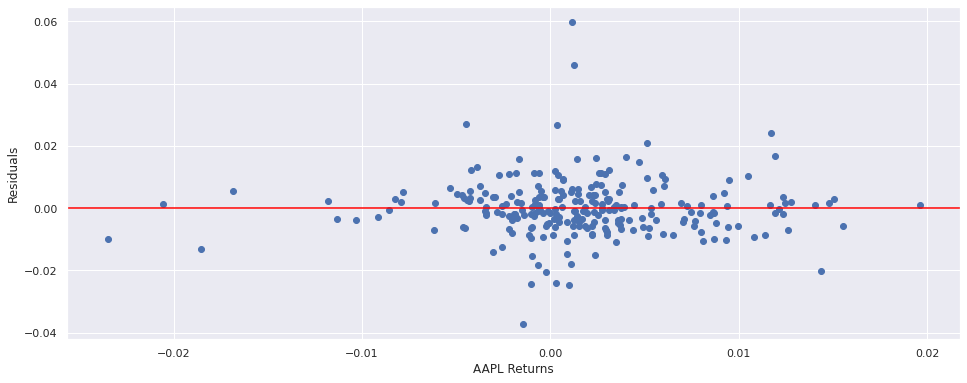

In [24]:
plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('AAPL Returns');
plt.ylabel('Residuals');

By simply observing the distribution of residuals, it does not seem as if there are any abnormalities. The distribution is relatively random and no patterns can be observed (the clustering around the origin is a result of the nature of returns to cluster around 0 and is not a red flag). Our qualitative conclusion is that the data is homoscedastic and not autocorrelated and therefore satisfies the assumptions for linear regression.

## Breusch-Pagan Heteroscedasticity Test

Our qualitative assessment of the residual plot is nicely supplemented with a couple statistical tests. Let's begin by testing for heteroscedasticity using a Breusch-Pagan test. Using the `het_breuschpagan` function from the statsmodels package:

In [25]:
bp_test = smd.het_breuschpagan(residuals, model.model.exog)

print("Lagrange Multiplier Statistic:", bp_test[0])
print("P-value:", bp_test[1])
print("f-value:", bp_test[2])
print("f_p-value:", bp_test[3], "\n")
if bp_test[1] > 0.05:
    print("The relationship is not heteroscedastic.")
if bp_test[1] < 0.05:
    print("The relationship is heteroscedastic.")

Lagrange Multiplier Statistic: 0.048792903530908704
P-value: 0.8251771825434487
f-value: 0.04841200895257823
f_p-value: 0.8260309075133113 

The relationship is not heteroscedastic.


Because the P-value is greater than 0.05, we do not have enough evidence to reject the null hypothesis that the relationship is homoscedastic. This result matches up with our qualitative conclusion.

## Ljung-Box Autocorrelation Test

Let's also check for autocorrelation quantitatively using a Ljung-Box test. Using the `acorr_ljungbox` function from the statsmodels package and the default maximum lag:

In [26]:
ljung_box = smd.acorr_ljungbox(r_a, lags=1, return_df=True)
print("P-Values:", ljung_box.lb_pvalue.tolist(), "\n")
if (ljung_box.lb_pvalue < 0.05).any():
    print("The residuals are autocorrelated.")
else:
    print("The residuals are not autocorrelated.")

P-Values: [0.7154123872552114] 

The residuals are not autocorrelated.


Because the Ljung-Box test yielded p-values above 0.05 for all lags, we can conclude that the residuals are not autocorrelated. This result matches up with our qualitative conclusion.

After having visually assessed the residual plot of the regression and then backing it up using statistical tests, we can conclude that the data satisfies the main assumptions and the linear model is valid.

## References
* "Analysis of Financial Time Series", by Ruey Tsay

---

**Next Lecture:** [Dangers of Overfitting](Lecture19-Dangers-of-Overfitting.ipynb) 

[Back to Introduction](Introduction.ipynb) 

---

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by QuantRocket LLC ("QuantRocket"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, the authors have not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information believed to be reliable at the time of publication. QuantRocket makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*